# Molecule property regression with message-passing network

### Preamble

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch
import dgl
from dgl.data import QM9EdgeDataset
from tqdm import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

## QM9EdgeDataset
DGL provides a preloaded interface to this dataset of 130k molecules.
- https://docs.dgl.ai/en/0.8.x/generated/dgl.data.QM9EdgeDataset.html
- http://quantum-machine.org/datasets/

We want to train a graph neural network to regress the magnitude of the electric dipole moment $|\vec{\mu}|$ of the molecule, where:

$\vec{\mu} = \sum_{i} q_i \vec{x_i}$

The atoms (nodes) in each molecule (graph) contain the following features:
- `pos`: spatial coordinates (3 numbers)
- `attr`: additional properties (11 numbers)

For our task, we will restrict ourselves to _purely_ the spatial coordinates and the atomic number as input features.

In [3]:
data = QM9EdgeDataset(label_keys=['mu'])

Done loading data from cached files.


In [4]:
len(data)

130831

In [5]:
g, labels = data.__getitem__(100000)

Note: I needed `pip install --upgrade nbformat` after getting `ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed`

## Plotly visualization
Code in `visualizer.py`

In [6]:
from visualizer import draw_plotly
draw_plotly(g)

## Message-passing model
This simple graph neural network consists of three main network components:
1) Node feature encoding
2) Message passing blocks
3) Graph-level prediction

<img src="./model.jpeg">

In [7]:
from model import MoleculeMPNN

In [8]:
net = MoleculeMPNN()

In [9]:
### number of parameters ###
sum(p.numel() for p in net.parameters())

371713

In [10]:
### Modified from https://docs.dgl.ai/en/0.2.x/tutorials/basics/4_batch.html ### 
def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    labels = torch.row_stack(labels)
    return batched_graph, labels

### Train-val-test splits

In [20]:
train_dataset = torch.utils.data.Subset(data,range(100000))
valid_dataset = torch.utils.data.Subset(data,range(100000,105000))
test_dataset = torch.utils.data.Subset(data,range(110000,len(data)-1))

train_dataloader = DataLoader(train_dataset, batch_size=200, shuffle=True, collate_fn=collate, num_workers=0)
valid_dataloader = DataLoader(valid_dataset, batch_size=200, collate_fn=collate, num_workers=0)
test_dataloader  = DataLoader(test_dataset,  batch_size=1, collate_fn=collate, num_workers=0)

In [21]:
net(g)

tensor([[-0.1208]], grad_fn=<AddmmBackward0>)

## Training

In [22]:
from training import train_valid_loop

train_loss, valid_loss = train_valid_loop(net, train_dataloader, valid_dataloader, 10)

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:47<07:07, 47.51s/it]

Epoch:  0  Train loss:  2.071965068459511  Valid loss:  1.1980252361297608


 20%|██        | 2/10 [01:34<06:16, 47.11s/it]

Epoch:  1  Train loss:  1.2844843119382858  Valid loss:  1.2748289465904237


 30%|███       | 3/10 [02:23<05:34, 47.84s/it]

Epoch:  2  Train loss:  1.2532916470766067  Valid loss:  1.0422079825401307


 40%|████      | 4/10 [03:12<04:51, 48.64s/it]

Epoch:  3  Train loss:  1.1889004226922988  Valid loss:  0.9888024258613587


 50%|█████     | 5/10 [04:00<04:01, 48.33s/it]

Epoch:  4  Train loss:  1.1573650249242782  Valid loss:  1.0841595506668091


 60%|██████    | 6/10 [04:48<03:12, 48.08s/it]

Epoch:  5  Train loss:  1.150634229183197  Valid loss:  1.0147600519657134


 70%|███████   | 7/10 [05:37<02:25, 48.41s/it]

Epoch:  6  Train loss:  1.1319922761917114  Valid loss:  1.0436562478542328


 80%|████████  | 8/10 [06:25<01:36, 48.44s/it]

Epoch:  7  Train loss:  1.1026429507732391  Valid loss:  0.9152409839630127


 90%|█████████ | 9/10 [07:14<00:48, 48.42s/it]

Epoch:  8  Train loss:  1.0908961848020553  Valid loss:  0.9656018352508545


100%|██████████| 10/10 [08:04<00:00, 48.41s/it]

Epoch:  9  Train loss:  1.0575290385484695  Valid loss:  0.8901155745983124


In [23]:
### Reload stored values ###
train_loss = np.load('train_loss.npy')
valid_loss = np.load('valid_loss.npy')

In [24]:
### Load saved model ###
net.load_state_dict(torch.load('saved_model.pt',map_location=torch.device('cpu')))

<All keys matched successfully>

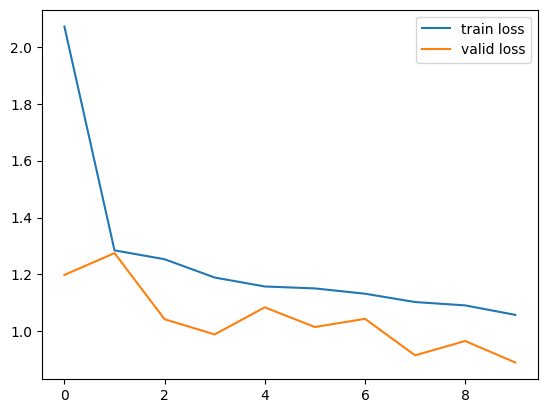

In [25]:
fig, axes = plt.subplots()
axes.plot(range(len(train_loss)),train_loss,label='train loss')
axes.plot(range(len(valid_loss)),valid_loss,label='valid loss')
#axes.set_yscale('log')
#axes.set_ylim([1e-2,1e0])
axes.legend()
plt.show()

## Performance evaluation

In [26]:
preds, trues = [], []

for i in tqdm(range(len(test_dataset))):
    g, labels = test_dataset.__getitem__(i)
    preds.append(net(g).detach().numpy().item())
    trues.append(labels.item())

preds = np.array(preds)
trues = np.array(trues)

100%|██████████| 20830/20830 [01:30<00:00, 230.78it/s]


### Predicted vs. true scatter plot

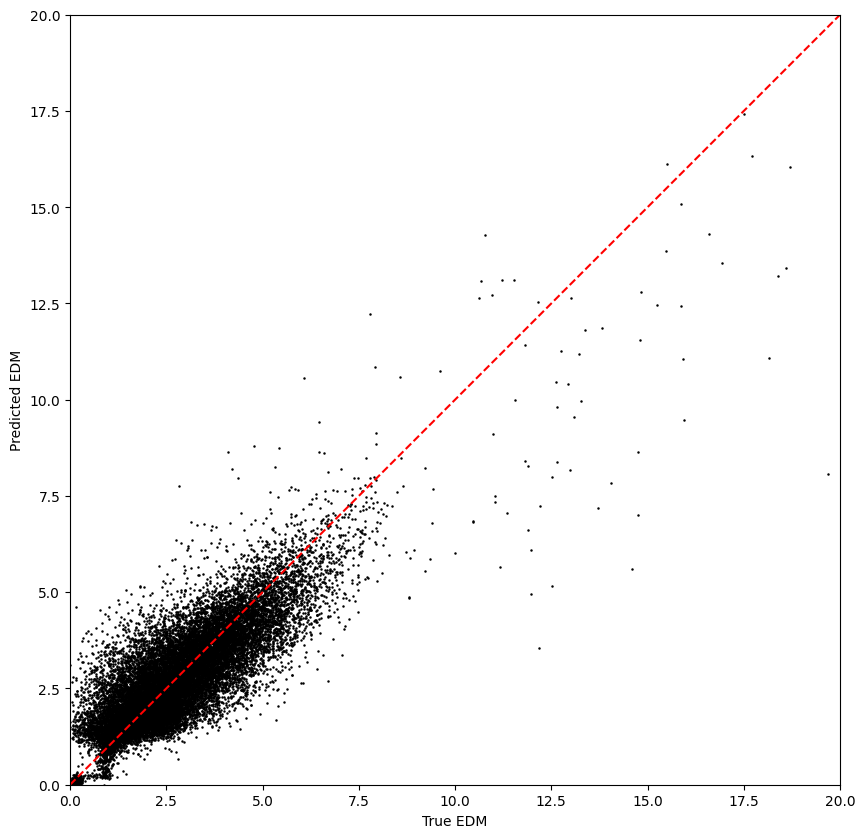

In [28]:
fig, axes = plt.subplots(figsize=(10,10))
axes.scatter(trues,preds,s=0.6,c='black')
axes.plot([0,20],[0,20],c='red',ls='--')
axes.set_xlabel('True EDM')
axes.set_ylabel('Predicted EDM')
axes.set_xlim(0,20)
axes.set_ylim(0,20)
axes.set_aspect('equal')

### Residual distribution

Text(0.5, 0, '(pred - true) / true')

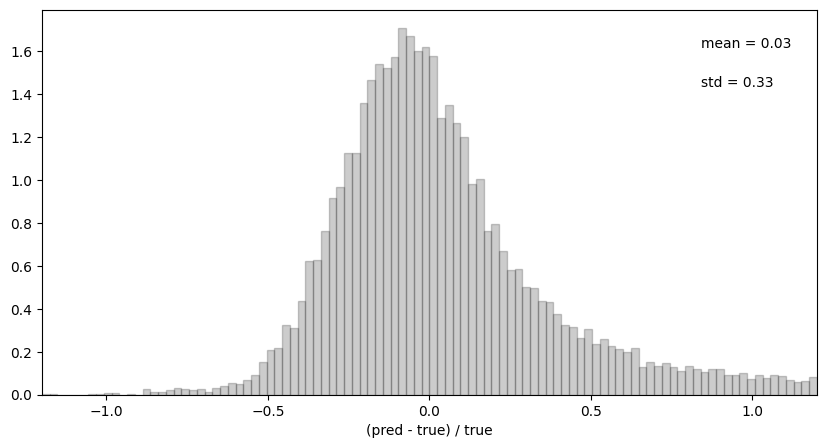

In [29]:
resids = (preds-trues)/(trues+1e-6)
resids = resids[abs(resids) < 1.2]

fig, axes = plt.subplots(figsize=(10,5))
h = axes.hist(resids,bins=100,range=(-1.2,1.2),facecolor='black',alpha=0.2,density=True,lw=1,edgecolor='black')
axes.set_xlim(-1.2,1.2)
axes.text(0.85,0.9,'mean = {:.2f}'.format(np.mean(resids)),transform=axes.transAxes)
axes.text(0.85,0.8,'std = {:.2f}'.format(np.std(resids)),transform=axes.transAxes)
axes.set_xlabel('(pred - true) / true')